# Post-processing for the eigenvalue problem

This notebook *should* contain the following sections:
- Plotting and filtering of eigenspectra;
- Visualization of selected eigenmodes

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
import utils, pgpy_utils, tools

---
## Eigenspectra

Read in data

In [67]:
import h5py

# fname = "./out/T1__eigenspec_non-garlerkin__m1__E_eta_1.0e-04__none_parities.h5"
# fname = "./out/T1pi__eigenspec__m1__E_eta_1.0e-10__none_parities.h5"
# fname = "./runs/T1_1e-4_m1_30-40_parity-same/eigenspectra.h5"
# fname = "./runs/T1pi_1e-4_m1_30-40_parity-same/eigenspectra.h5"
# fname = "./runs/S1_1e-6_m3_galerkin_30-40_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-6_m1_parity-oppo/eigenspectra_all.h5"
# fname = "./runs/S1pi_1e-6_m3_galerkin_30-40_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1_Em5e-9_Els5e-1_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1_Le1e-4_Lu1e+4_m3_parity_oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-9_m1_galerkin_60_parity-oppo/eigenspectra.h5"
# fname = "./runs/S1pi_1e-9_m3_galerkin_60_parity-oppo/eigenspectra.h5"
# fname = "./runs/M_ideal_Le1e-4_m3_30-40_parity-same/eigenspectra.h5"
fname = "./runs/S1pi_Le1e-4_Lu5e+4_m3_parity_oppo/eigenspectra.h5"

# Which parity to choose. If both QP and DP, use "both"; if the parity is not separated, use None
parity_mode = "DP"

meta = list()
spectra = list()
with h5py.File(fname, 'r') as fread:
    n_res = len([key for key in fread.keys() if key[:9] == "eigenspec"])
    for i_res in range(n_res):
        gp = fread[f"eigenspec_res{i_res}"]
        meta.append({key: gp.attrs[key] for key in gp.attrs.keys()})
        if parity_mode is None:
            spectra.append(gp["spectrum"][()])
        elif parity_mode == "both":
            spectra.append(np.concatenate((gp["spectrum_QP"][()], gp["spectrum_DP"][()])))
        else:
            spectra.append(gp["spectrum_%s" % parity_mode][()])

In [68]:
meta

[{'L': 43, 'N': 43, 'm': 3}, {'L': 63, 'N': 63, 'm': 3}]

Sorting eigenvalues (optional)

In [69]:
for i_w, w in enumerate(spectra):
    sort_idx = np.argsort(np.imag(w))
    spectra[i_w] = w[sort_idx]

Convert to Alfven scale (optional)

In [34]:
scale = np.sqrt(1e-9/1.0)

for i_w, w in enumerate(spectra):
    spectra[i_w] = scale*w

### Eigenvalue drift plot

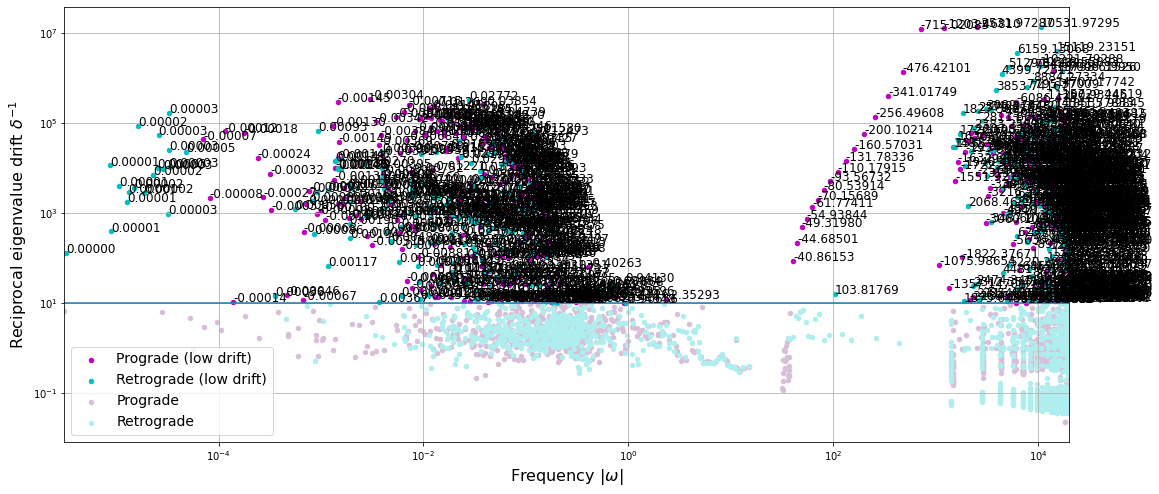

In [70]:
eig_base, eig_comp = spectra[0], spectra[1]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp, mode="global")

fig, ax = plt.subplots(figsize=(18, 8))

threshold = 1e+1
reciproc = 1./drift
idx = np.arange(drift.size)

classify_list = [
    [lambda x: (x.imag < 0) & (reciproc > threshold), {"s": 20, "marker": 'o', "color": "m", "label": "Prograde (low drift)"}],
    [lambda x: (x.imag >= 0) & (reciproc > threshold), {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde (low drift)"}],
    [lambda x: (x.imag < 0) & (reciproc <= threshold), {"s": 20, "marker": 'o', "color": "thistle", "label": "Prograde"}],
    [lambda x: (x.imag >= 0) & (reciproc <= threshold), {"s": 20, "marker": 'o', "color": "paleturquoise", "label": "Retrograde"}]
]

# classify_list = [
#     [lambda x: (x.imag < 1) & (x.imag > 0) & (reciproc > threshold), {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde (low drift)"}],
# ]


for classifier in classify_list:
    class_idx = classifier[0](eig_base)
    ax.scatter(np.abs(eig_base[class_idx].imag), reciproc[class_idx], **classifier[1])

for idx_tmp in idx[reciproc > threshold]:
    ax.annotate("{:.5f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=12)

ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=14, loc=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
# ax.set_xlim([1e-3, 1])
ax.set_xlabel(r"Frequency $|\omega|$", fontsize=16)
ax.set_ylabel(r"Reciprocal eigenvalue drift $\delta^{-1}$", fontsize=16)
ax.grid(which="both")

plt.show()

Eigenvalues in different resolutions in $\omega$-$\sigma$ space

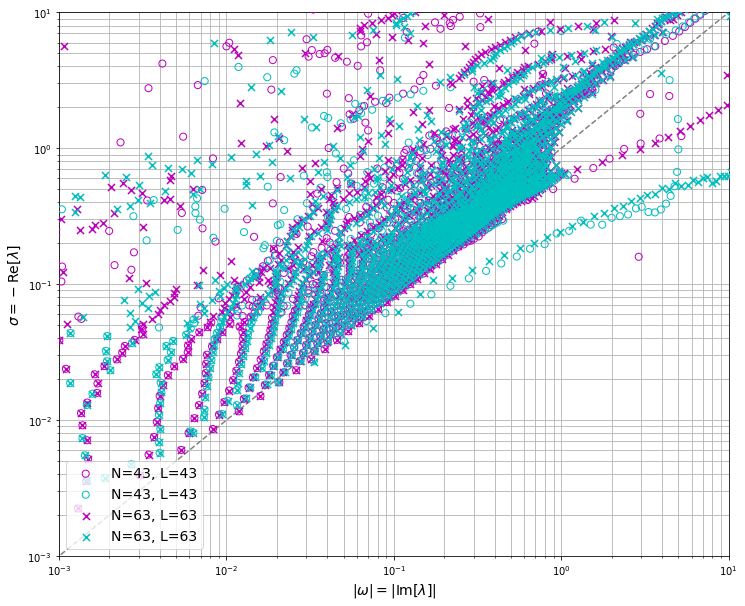

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))

vrange = [np.log10(reciproc.min()), np.log10(reciproc.max())]

view_indices = [0, 1]
res_style_list = [
    # {"s": 50, "marker": 's', "facecolor": "none"},
    {"s": 50, "marker": 'o', "facecolor": "none"},
    {"s": 50, "marker": 'x'}
]

classify_list = [
    [lambda x: (x.imag < 0), {"color": 'm'}],
    [lambda x: (x.imag >= 0), {"color": 'c'}],
]

for i_view, i_res in enumerate(view_indices):
    spec = spectra[i_res]
    for classifier in classify_list:
        class_idx = classifier[0](spec)
        im = ax.scatter(np.abs(np.imag(spec[class_idx])), -np.real(spec[class_idx]), 
            **classifier[1], **res_style_list[i_view], label=f"N={meta[i_res]['N']}, L={meta[i_res]['L']}", zorder=4)

ax.plot([1e-6, 1e+8], [1e-6, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([1e-2, 1.5e+6])
# ax.set_ylim([1e-2, 1.0e+6])
# ax.set_xlim([1e+1, 1.0e+4])
# ax.set_ylim([1e+1, 1.0e+4])
# ax.set_xlim([1e-6, 3.0e+4])
# ax.set_ylim([1e-5, 1.5e+2])
ax.set_xlim([1e-3, 1.0e+1])
ax.set_ylim([1e-3, 1.0e+1])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

plt.show()

Reciprocal eigenvalue drift in $\omega$-$\sigma$ space

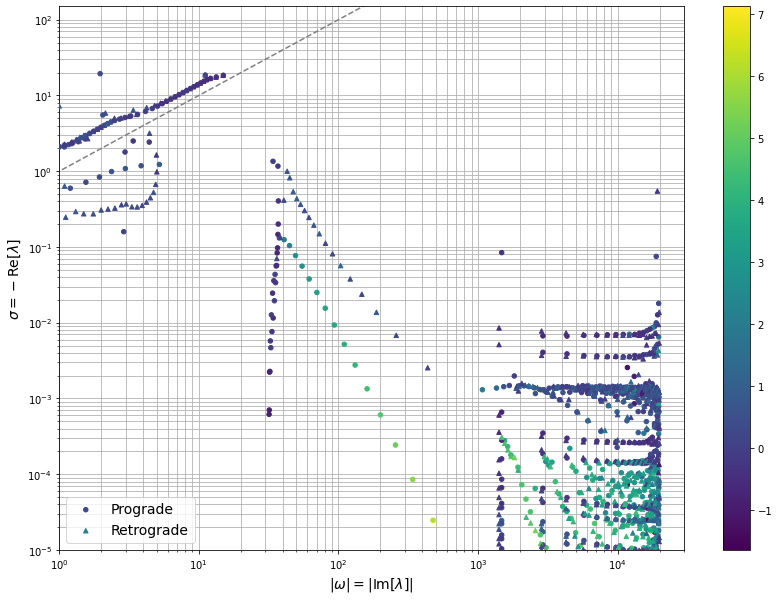

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))

vrange = [np.log10(reciproc.min()), np.log10(reciproc.max())]

classify_list = [
    [lambda x: (x.imag < 0), {"s": 20, "marker": 'o', "label": "Prograde", "vmin": vrange[0], "vmax": vrange[1]}],
    [lambda x: (x.imag >= 0), {"s": 20, "marker": '^', "label": "Retrograde", "vmin": vrange[0], "vmax": vrange[1]}],
]

for classifier in classify_list:
    class_idx = classifier[0](eig_base)
    im = ax.scatter(np.abs(np.imag(eig_base[class_idx])), -np.real(eig_base[class_idx]), c=np.log10(reciproc[class_idx]), **classifier[1], zorder=5)

plt.colorbar(im, ax=ax)

ax.plot([1e-6, 1e+8], [1e-6, 1e+8], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([1e-2, 1.5e+6])
# ax.set_ylim([1e-2, 1.0e+6])
# ax.set_xlim([1e-2, 1.5e+4])
# ax.set_xlim([1e-1, 1.5e+6])
# ax.set_ylim([1e-2, 1e+4])
ax.set_xlim([1e-0, 3e+4])
ax.set_ylim([1e-5, 1.5e+2])
# ax.set_xlim([1e-1, 2.0e+2])
# ax.set_ylim([1e-1, 4.0e+1])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

plt.show()

### Filtered eigenspectrum

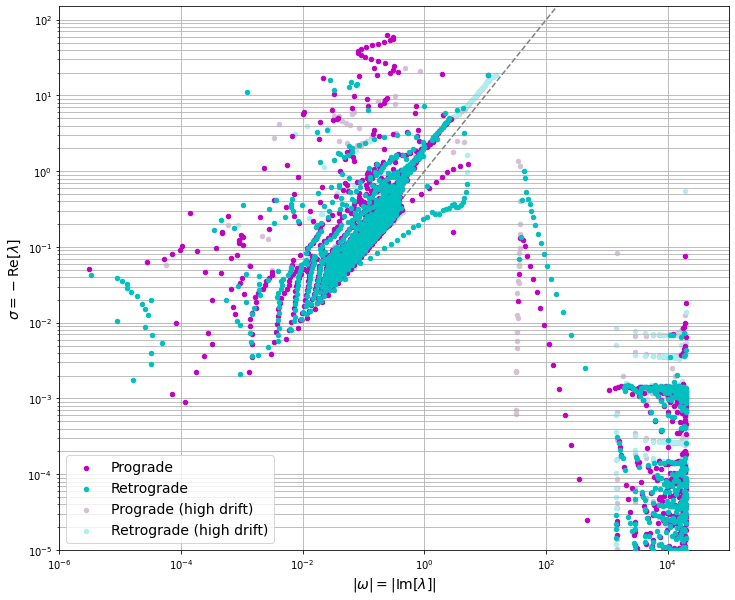

In [73]:
threshold = 1e+0
converge_filter = reciproc > threshold

# spectrum_converged = eig_base[converge_filter]
spectrum_converged = eig_base

classify_list = [
    [lambda x: x.imag < -1e-7, {"s": 20, "marker": 'o', "color": "m", "label": "Prograde"}],
    [lambda x: x.imag > +1e-7, {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde"}]
]
classify_list = [
    [lambda x: (x.imag < -1e-7) & (reciproc > threshold), 
     {"s": 20, "marker": 'o', "color": "m", "label": "Prograde", "zorder": 5}],
    [lambda x: (x.imag > +1e-7) & (reciproc > threshold), 
     {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde", "zorder": 5}],
    [lambda x: (x.imag < -1e-7) & (reciproc <= threshold), 
     {"s": 20, "marker": 'o', "color": "thistle", "label": "Prograde (high drift)", "zorder": 1}],
    [lambda x: (x.imag > +1e-7) & (reciproc <= threshold), 
     {"s": 20, "marker": 'o', "color": "paleturquoise", "label": "Retrograde (high drift)", "zorder": 1}]
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))

for classifier in classify_list:
    class_idx = classifier[0](spectrum_converged)
    ax.scatter(np.abs(np.imag(spectrum_converged[class_idx])), -np.real(spectrum_converged[class_idx]), **classifier[1])

ax.plot([1e-2, 1e+4], [1e-2, 1e+4], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([1e-1, 1.5e+6])
# ax.set_ylim([1e-1, 1.0e+6])
# ax.set_xlim([1e-2, 1.5e+4])
# ax.set_xlim([1e-1, 1.5e+6])
# ax.set_ylim([0.5e-2, 1e+4])
# ax.set_xlim([1e-5, 3.0e+4])
# ax.set_ylim([1e-5, 1.5e+2])
ax.set_xlim([1e-6, 1.0e+5])
ax.set_ylim([1e-5, 1.5e+2])
# ax.set_xlim([1e-1, 2.0e+1])
# ax.set_ylim([1e-1, 4.0e+0])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

# plt.savefig("./out/eigenspec_T1__E1e-4_m1_N40__QP_thresh_1e8.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

### Comparison Malkus model

In [29]:
import pandas as pd

omega_fast, omega_slow = pgpy_utils.eigenfreq_Malkus_3d(m=3, n=np.arange(1, 20), Le=np.sqrt(2)*1e-4, mode="all", timescale="alfven")

df_original = pd.DataFrame(data={"Fast": omega_fast, "Slow": omega_slow})
df_original

,Fast,Slow
0,-1790.380480,0.005451
1,-839.627837,0.011143
2,-499.792484,0.018432
3,-333.877916,0.027380
4,-239.470838,0.038007
5,-180.382336,0.050318
6,-140.867145,0.064314
7,-113.110654,0.079992
8,-92.857195,0.097347
9,-77.621875,0.116370


In [31]:
b_pref = 2*np.sqrt(np.pi/3)
Le_pref = np.sqrt(2)
omega_fast, omega_slow = pgpy_utils.eigenfreq_Malkus_3d(m=3, n=np.arange(1, 20), Le=Le_pref*np.sqrt(2)*1e-4, mode="all", timescale="alfven")

df_scaled = pd.DataFrame(data={"Fast": omega_fast*Le_pref, "Slow": omega_slow*Le_pref})
df_scaled

,Fast,Slow
0,-1790.385931,0.010902
1,-839.638980,0.022286
2,-499.810915,0.036862
3,-333.905291,0.054756
4,-239.508833,0.076002
5,-180.432626,0.100608
6,-140.931401,0.128569
7,-113.190534,0.159871
8,-92.954339,0.194490
9,-77.737898,0.232393


In [26]:
spectra[1][(reciproc > 1e+2) & (spectra[1].imag > 1e-3) & (spectra[1].imag < 1)]
# spectra[1][(reciproc > 1e+4) & (spectra[1].imag < 0)]

array([-1.07292790e-08+0.0015428j ,  3.51933742e-11+0.00177292j,
        2.66224128e-09+0.00198239j,  2.07175263e-09+0.00210012j,
        6.87994566e-09+0.00321739j, -2.22426649e-11+0.00582257j,
       -1.36651752e-08+0.25582753j, -1.01941042e-20+0.25582756j,
        1.60155943e-12+0.25582757j, -4.86101668e-13+0.25582757j,
       -3.96482053e-13+0.25582757j, -1.72323545e-12+0.25582757j,
        1.12698150e-20+0.25582757j,  5.56864117e-13+0.25582757j,
       -3.24640971e-13+0.25582757j,  6.96252048e-13+0.25582757j,
       -2.47991110e-13+0.25582757j,  7.79789473e-22+0.25582757j,
        1.73225119e-13+0.25582757j, -1.51957875e-13+0.25582757j,
       -5.33426939e-14+0.25582757j,  5.40614498e-20+0.25582757j,
       -1.19974021e-13+0.25582757j,  6.68106419e-14+0.25582757j,
        3.03952456e-20+0.25582757j, -2.16762332e-13+0.25582757j,
        4.35708003e-14+0.25582757j,  1.98241706e-17+0.25582757j,
        1.62153414e-13+0.25582757j, -3.49508831e-19+0.25582757j,
        2.32822951e-22+0.

---
## Eigenmodes

In [74]:
import models
from operators.polynomials import SphericalHarmonicMode
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM

In [113]:
nr, maxnl, m_val = 63, 123, 3  # resolution
field_modes = [SphericalHarmonicMode("pol", 1, 0, "1/5 Sqrt[pi/3] r(5-3r^2)")]  # define background field
model = models.MagnetoCoriolis_Alfven(nr, maxnl, m_val, inviscid=True)  # construct model object
# construct left and right matrix operator
A, B = model.setup_operator(field_modes=field_modes, setup_eigen=True, lehnert=1e-4, lundquist=5e+4)

In [180]:
w, v = utils.single_eig(
    A, B, 
    # target= -3.6e-2 + 5e-2j, 
    # target = -2.5e-2 + 3.3e-2j,
    # target = -2.0e-2 + 2.0e-2j,
    # target = -6.0e-4 - 2.0e+2j,
    # target = -5.0e-5 - 4.8e+2j,
    # target = -1.0e-4 - 3.3e+2j,
    target = -1.0e-3 - 2.6e+2j,
    nev=10
)
w

array([-2.26715465e-01-257.69344176j, -1.23132759e-01-263.465975j  ,
       -4.47485049e-04-256.49642759j, -8.90339850e-01-267.55936747j,
        3.41016378e-01-267.62341764j, -2.03581069e-01-247.02853215j,
       -2.47932178e-01-272.43924962j, -7.31465416e-01-276.06351705j,
        2.85438814e-01-276.61698685j, -2.38384478e-01-281.78507018j])

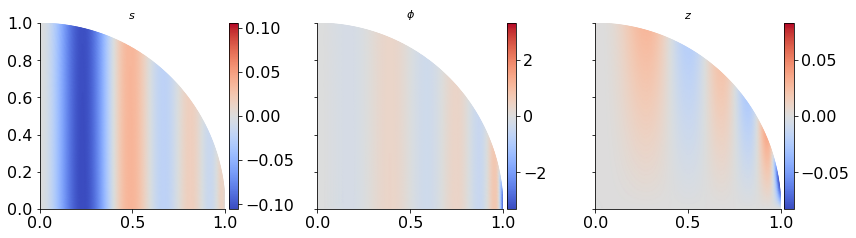

In [182]:
# get spectrum object and normalise to b with energy 1
# dim = v.shape[0] // 2
usp = VectorFieldSingleM(nr, maxnl, m_val, v[:model.dim['u'], 2])
# bsp = VectorFieldSingleM(nr, maxnl, m_val, v[dim:, 0])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
# bsp.normalise(norm)

# compute physical field on a meridional slice
rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

uphy = usp.physical_field(worland_transform, legendre_transform)
# bphy = bsp.physical_field(worland_transform, legendre_transform)

# visualise field components
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=1, sharey=True, sharex=True)
uphy.visualise(name='u', coord='cylindrical', ylim=[0, 1], phi=1/8*np.pi, ax=axes)
# bphy.visualise(name='b', coord='spherical', ax=axes[1])
fig.tight_layout()

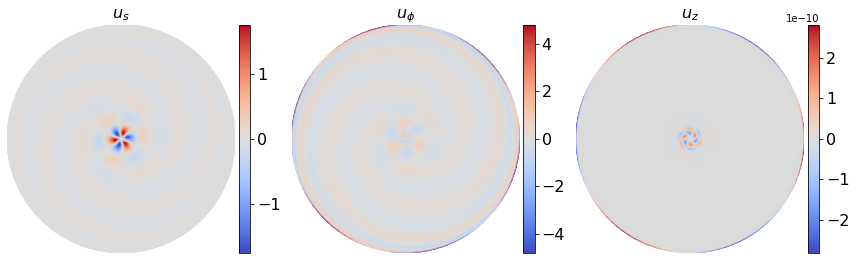

In [170]:
# get spectrum object and normalise to b with energy 1
# dim = v.shape[0] // 2
usp = VectorFieldSingleM(nr, maxnl, m_val, v[:model.dim['u'], 0])
# bsp = VectorFieldSingleM(nr, maxnl, m_val, v[dim:, 0])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
# bsp.normalise(norm)

# compute physical field on an equatorial slice
rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

uphy_eq = usp.equatorial_slice(worland_transform)
# bphy = bsp.physical_field(worland_transform, legendre_transform)

# visualise field components
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=1, sharey=True, sharex=True)
uphy_eq.visualise(nphi=100, field_name='u', coord='cylindrical', ax=axes)
# bphy.visualise(name='b', coord='spherical', ax=axes[1])
fig.tight_layout()

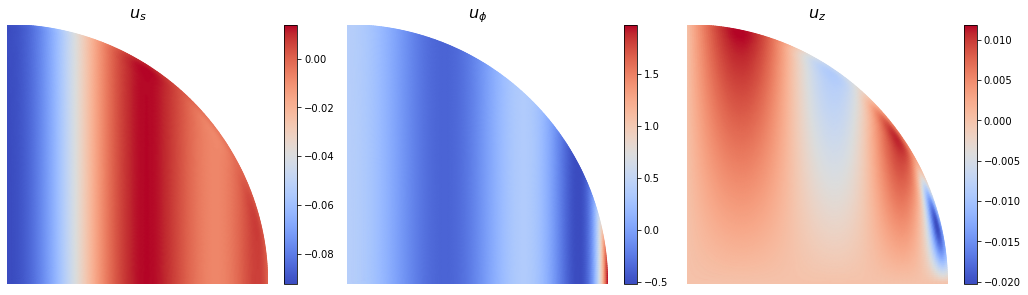

In [326]:
plot_fields = [["s", "phi", "z"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],]

# save_name = "./out/eigen/Hydrodynamic/Reduced/mode_meridional_m3n10"
save_name = None
override = False

force_symmetric_cmap = True

rr, tt = np.meshgrid(uphy.grid['r'], uphy.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)
field_sph = uphy.at_phi(phi=0)
field_cyl = {
    's': field_sph['r']*np.sin(tt) + field_sph['theta']*np.cos(tt),
    'phi': field_sph['phi'],
    'z': field_sph['r']*np.cos(tt) - field_sph['theta']*np.sin(tt)
}

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = field_cyl[plot_fields[i_r][i_c]]
        if np.abs(np.real(field_plot)).max() > 1e-5:
            if force_symmetric_cmap:
                # climit = np.max(np.abs(np.real(eigmode_eval[fname])/max_norm))
                # cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                cm = ax.pcolormesh(X1, X2, field_plot, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            # cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            cm = ax.pcolormesh(X1, X2, field_plot)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [15]:
eigenvals = list()
eigenvecs = list()
with h5py.File("./runs/S1pi_1e-6_m1_parity-oppo/eigenmodes.h5", 'r') as fread:
    n_gps = len(fread.keys())
    for i_gps in range(n_gps):
        eigenvals.append(fread[f"eigenmode_target{i_gps}"]["eigenvals"][()])
        eigenvecs.append(fread[f"eigenmode_target{i_gps}"]["eigenvecs"][()])

In [16]:
eigenvals

[array([ -9.943947  -0.19453906j, -19.85299349-1.59664116j,
        -21.4900355 -2.46617499j, -34.37948626+2.89752846j,
        -34.59870721-1.39923424j]),
 array([-49.44493756 +0.57772937j, -59.8202957  -2.87960945j,
        -34.37948626 +2.89752846j, -34.59870721 -1.39923424j,
        -38.31587302-14.43118207j]),
 array([-19.85299349-1.59664116j, -21.4900355 -2.46617499j,
         -9.943947  -0.19453906j, -34.37948626+2.89752846j,
        -34.59870721-1.39923424j]),
 array([-55.31349344+21.55398426j, -49.44493756 +0.57772937j,
        -34.37948626 +2.89752846j, -34.59870721 -1.39923424j,
        -59.8202957  -2.87960945j]),
 array([-104.64462797+38.15274137j, -129.53446271+36.03918932j,
        -138.60030971+18.66784603j,  -81.51948745+19.51540918j,
        -113.60189706 +0.95385072j]),
 array([-147.33659437+68.60453335j, -149.29678226+50.23110807j,
        -192.51151705+74.27315963j, -129.53446271+36.03918932j,
        -138.60030971+18.66784603j]),
 array([-261.33678842+178.19496546

In [19]:
nr, maxnl, m_val = 61, 61, 1  # resolution
model = models.MagnetoCoriolis(nr, maxnl, m_val, inviscid=True)  # construct model object

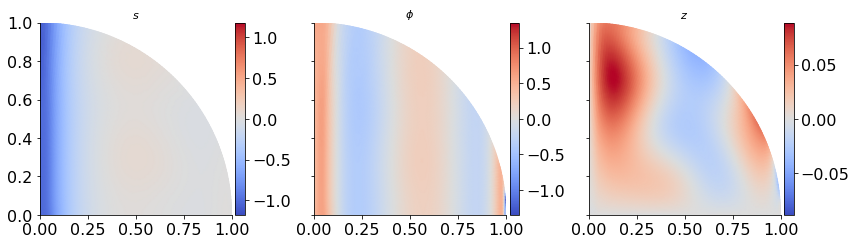

In [297]:
# get spectrum object and normalise to b with energy 1
# dim = v.shape[0] // 2
usp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[5][:model.dim['u'], 0])
# bsp = VectorFieldSingleM(nr, maxnl, m_val, v[dim:, 0])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
# bsp.normalise(norm)

# compute physical field on a meridional slice
rg = np.linspace(0, 1, 201)
tg = np.linspace(0, np.pi, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)

uphy = usp.physical_field(worland_transform, legendre_transform)
# bphy = bsp.physical_field(worland_transform, legendre_transform)

# visualise field components
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=1, sharey=True, sharex=True)
uphy.visualise(name='u', coord='cylindrical', ax=axes)
# bphy.visualise(name='b', coord='spherical', ax=axes[1])
fig.tight_layout()

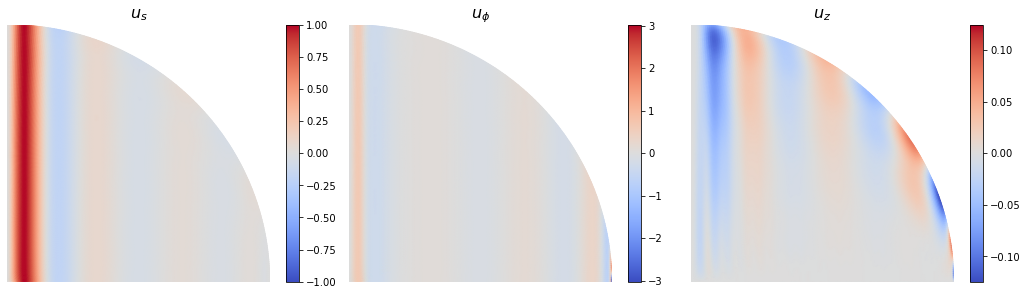

In [179]:
import os

plot_fields = [["s", "phi", "z"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$"],]

save_name = "./runs/S1pi_Le1e-4_Lu5e+4_m3_parity_oppo/mode_meridional_m3n7_slow"
# save_name = None
override = False

force_symmetric_cmap = True

rr, tt = np.meshgrid(uphy.grid['r'], uphy.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)
field_sph = uphy.at_phi(phi=0*np.pi)
field_cyl = {
    's': field_sph['r']*np.sin(tt) + field_sph['theta']*np.cos(tt),
    'phi': field_sph['phi'],
    'z': field_sph['r']*np.cos(tt) - field_sph['theta']*np.sin(tt)
}
max_norm = np.abs(field_cyl['s']).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = field_cyl[plot_fields[i_r][i_c]]
        if np.abs(np.real(field_plot)).max() > 1e-5:
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/max_norm))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, -field_plot/max_norm, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                # cm = ax.pcolormesh(X1, X2, field_plot, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            # cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            cm = ax.pcolormesh(X1, X2, field_plot)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()